In [1]:
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
RESEARCH_DATA = os.environ.get("RESEARCH_DATA")

EL = "attempt_1"

METHODS = {
    "mutCnt": (10, 10)
}

RID_RANGE = (1, 10)

TOP_N = [1, 3, 5, 10]

dlfl_out_base_dir = os.path.join(RESEARCH_DATA, EL, "dlfl_out")
dlfl_raw_dir = os.path.join(dlfl_out_base_dir, "experiment_raw_results_sbfl")
dlfl_information_dir = os.path.join(dlfl_out_base_dir, "experiment_information_results_sbfl")
if not os.path.exists(dlfl_information_dir):
    os.makedirs(dlfl_information_dir)


In [3]:
def calculate_exp_results():
    default = {
        "topN": {n: [] for n in TOP_N},
        "mfr_list": [],
        "mar_list": [],

    }
    exp_results = {}
    for method, (start, end) in METHODS.items():
        for method_id in range(start, end+1):
            method_name = f"{method}_{method_id}"
            exp_results[method_name] = copy.deepcopy(default)

            for rid in range(RID_RANGE[0], RID_RANGE[1]+1):
                result_path = os.path.join(dlfl_raw_dir, f"repeat_{rid}", "methods", method_name, "final_results.json")
                if not os.path.exists(result_path):
                    raise FileNotFoundError(f"Result file not found: {result_path}")
                
                with open(result_path, "r") as f:
                    result = json.load(f)["total"]

                for n in TOP_N:
                    exp_results[method_name]["topN"][n].append(result[f"top{n}"])

                exp_results[method_name]["mfr_list"].append(result["mfr"])
                exp_results[method_name]["mar_list"].append(result["mar"])


            exp_results[method_name]["topN_mean"] = {n: np.mean(exp_results[method_name]["topN"][n]) for n in TOP_N}
            exp_results[method_name]["topN_std"] = {n: np.std(exp_results[method_name]["topN"][n]) for n in TOP_N}
            exp_results[method_name]["mfr_mean"] = np.mean(exp_results[method_name]["mfr_list"])
            exp_results[method_name]["mfr_std"] = np.std(exp_results[method_name]["mfr_list"])
            exp_results[method_name]["mar_mean"] = np.mean(exp_results[method_name]["mar_list"])
            exp_results[method_name]["mar_std"] = np.std(exp_results[method_name]["mar_list"])

    return exp_results

In [4]:
exp_result = calculate_exp_results()

In [5]:
# Save the results to a csv
def save_results_to_csv(exp_result):
    csv_path = os.path.join(dlfl_information_dir, "average_results.csv")

    data = []
    for method, results in exp_result.items():
        row = {
            "Technique": method,
            "Top-1_mean": results["topN_mean"][1],
            "Top-1_std": results["topN_std"][1],
            "Top-3_mean": results["topN_mean"][3],
            "Top-3_std": results["topN_std"][3],
            "Top-5_mean": results["topN_mean"][5],
            "Top-5_std": results["topN_std"][5],
            "Top-10_mean": results["topN_mean"][10],
            "Top-10_std": results["topN_std"][10],
            "MFR_mean": results["mfr_mean"],
            "MFR_std": results["mfr_std"],
            "MAR_mean": results["mar_mean"],
            "MAR_std": results["mar_std"]
        }
        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)

    

In [6]:
save_results_to_csv(exp_result)

In [7]:
def plot_topN_line_graphs(exp_result, save_graphs=True):

    if save_graphs:
        graphs_dir = os.path.join(dlfl_information_dir, "graphs")
        if not os.path.exists(graphs_dir):
            os.makedirs(graphs_dir)

    x_values = list(range(METHODS["mutCnt"][0], METHODS["mutCnt"][1] + 1))

    plt.figure(figsize=(15, 10))
    for i, top_n in enumerate(TOP_N, 1):
        plt.subplot(2, 2, i)

        mean = [exp_result[method][f"topN_mean"][top_n] for method in exp_result]
        std = [exp_result[method][f"topN_std"][top_n] for method in exp_result]
        line1 = plt.plot(x_values, mean, label=f"DLFL", marker='x', linewidth=2)
        color = line1[0].get_color()
        plt.fill_between(x_values,
                         [m - s for m, s in zip(mean, std)],
                         [m + s for m, s in zip(mean, std)],
                         alpha=0.3, color=color, label=f"DLFL ±1σ")
        
        plt.ylim(0, 100)
        plt.title(f"Top-{top_n}", fontsize=14)
        plt.xlabel("# of Mutants per line", fontsize=12)
        plt.ylabel(f"Top-{top_n}", fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
        plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()

    if save_graphs:
        plt.savefig(os.path.join(graphs_dir, "topN_line_graphs.png"), dpi=300)
    plt.show()

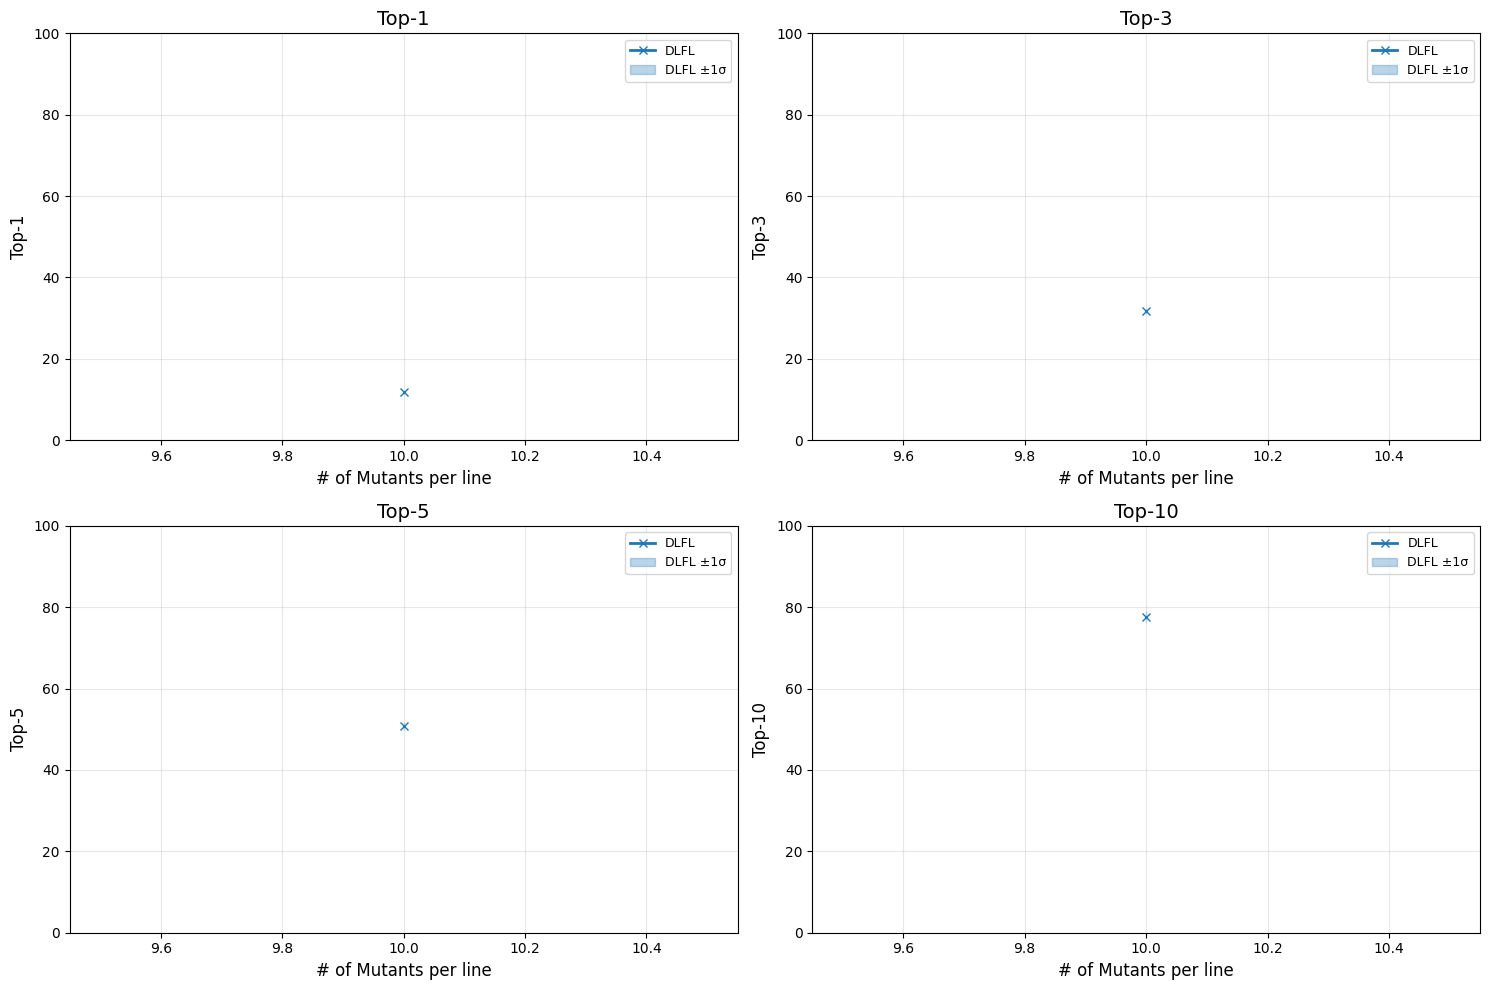

In [8]:
plot_topN_line_graphs(exp_result, save_graphs=True)

In [9]:
def plot_mfr_mar_line_graphs(exp_result, save_graphs=True):
    if save_graphs:
        graphs_dir = os.path.join(dlfl_information_dir, "graphs")
        if not os.path.exists(graphs_dir):
            os.makedirs(graphs_dir)

    x_values = list(range(METHODS["mutCnt"][0], METHODS["mutCnt"][1] + 1))

    plt.figure(figsize=(15, 10))
    
    # MFR
    plt.subplot(2, 2, 1)
    mean_mfr = [exp_result[method]["mfr_mean"] for method in exp_result]
    std_mfr = [exp_result[method]["mfr_std"] for method in exp_result]
    line1 = plt.plot(x_values, mean_mfr, label="DLFL", marker='x', linewidth=2)
    color = line1[0].get_color()
    plt.fill_between(x_values,
                     [m - s for m, s in zip(mean_mfr, std_mfr)],
                     [m + s for m, s in zip(mean_mfr, std_mfr)],
                     alpha=0.3, color=color, label="DLFL ±1σ")
    
    plt.ylim(0, 70)
    plt.title("MFR", fontsize=14)
    plt.xlabel("# of Mutants per line", fontsize=12)
    plt.ylabel("MFR", fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # MAR
    plt.subplot(2, 2, 2)
    mean_mar = [exp_result[method]["mar_mean"] for method in exp_result]
    std_mar = [exp_result[method]["mar_std"] for method in exp_result]
    line2 = plt.plot(x_values, mean_mar, label="DLFL", marker='x', linewidth=2)
    color = line2[0].get_color()
    plt.fill_between(x_values,
                     [m - s for m, s in zip(mean_mar, std_mar)],
                     [m + s for m, s in zip(mean_mar, std_mar)],
                     alpha=0.3, color=color, label="DLFL ±1σ")
    
    plt.ylim(0, 70)
    plt.title("MAR", fontsize=14)
    plt.xlabel("# of Mutants per line", fontsize=12)
    plt.ylabel("MAR", fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()

    if save_graphs:
        plt.savefig(os.path.join(graphs_dir, "mfr_mar_line_graphs.png"), dpi=300)
    plt.show()

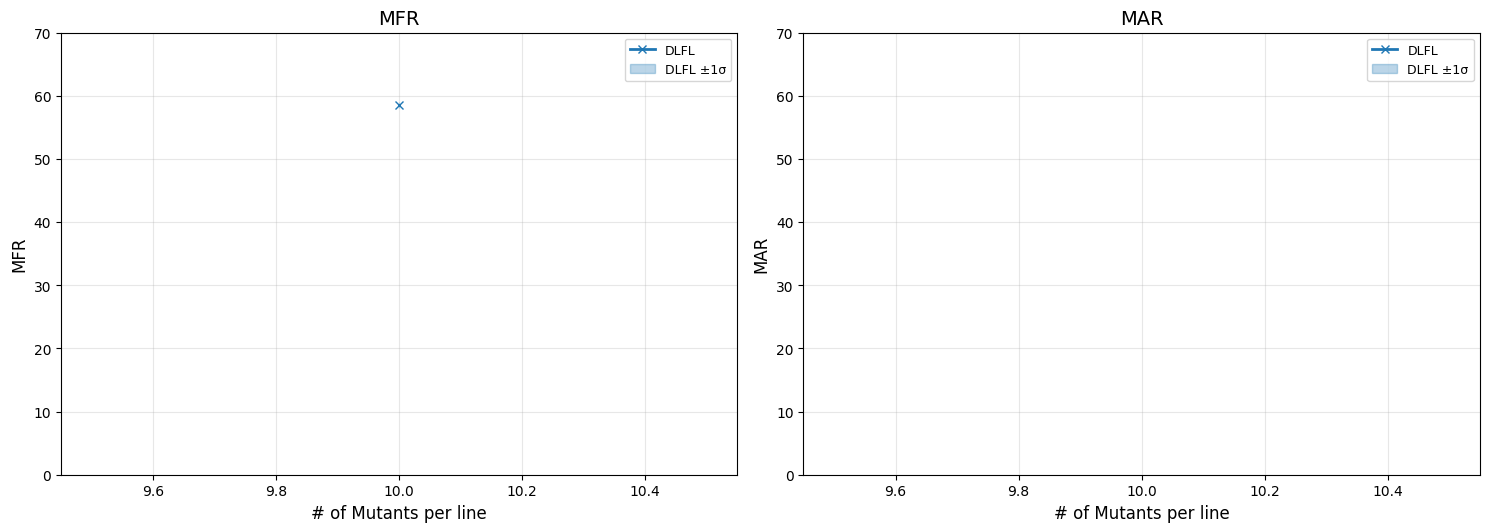

In [10]:
plot_mfr_mar_line_graphs(exp_result, save_graphs=True)